In [3]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
%matplotlib inline

In [4]:
import talib
from ta import add_all_ta_features

### Read full database

In [5]:
DATA_PATH = r'../data/'
FILE_NAME = '20220313_034756_111.pkl'
FULL_PATH = Path(DATA_PATH,FILE_NAME)

In [35]:
%time
raw = pd.read_pickle(FULL_PATH)
raw.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


(5675397, 14)

In [37]:
raw.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                                object
high                                object
low                                 object
close                               object
volume                              object
numTrades                            int64
quoteAssetVolume                    object
takerBuyBaseAssetVolume             object
takerBuyQuoteAssetVolume            object
dtype: object

In [38]:
raw.symbol.value_counts()

BTCUSDT     87964
ETHUSDT     80325
BCHUSDT     78208
XRPUSDT     76486
EOSUSDT     76292
            ...  
BAKEUSDT    28582
BTTUSDT     28339
GTCUSDT     26390
TLMUSDT     23032
KEEPUSDT    22843
Name: symbol, Length: 111, dtype: int64

### Prepare and subset dataset

In [265]:
df = raw.query('symbol=="ETHUSDT"')
assert df.isnull().sum().sum() == 0
df.shape

(80325, 14)

In [266]:
# create datatypes dictionary
datatypes = {k:'float32' if k!='numTrades' else 'int32' for k in df.loc[:,'open':].columns}
# assign datatypes
df = df.astype(datatypes)
assert df.isnull().sum().sum() == 0
df.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                               float32
high                               float32
low                                float32
close                              float32
volume                             float32
numTrades                            int32
quoteAssetVolume                   float32
takerBuyBaseAssetVolume            float32
takerBuyQuoteAssetVolume           float32
dtype: object

In [268]:
df.to_pickle('../data/eth.pkl')

### Read dataset from disk

In [5]:
raw = pd.read_pickle('../data/eth.pkl')

### Group on desired frequency

In [209]:
df = \
    raw.groupby(pd.Grouper(key="openTime", freq="1H"))\
    .agg(
        cnt=pd.NamedAgg(column="symbol", aggfunc="size"),
        opentime=pd.NamedAgg(column="openTime", aggfunc="min"),
        closetime=pd.NamedAgg(column="openTime", aggfunc="min"),
        open=pd.NamedAgg(column="open", aggfunc="first"),
        high=pd.NamedAgg(column="high", aggfunc="max"),
        low=pd.NamedAgg(column="low", aggfunc="min"),
        close=pd.NamedAgg(column="close", aggfunc="last"),
        volume=pd.NamedAgg(column="volume", aggfunc="sum"),
        numtrade=pd.NamedAgg(column="numTrades", aggfunc="sum"),
    )\
    .query('cnt >= 4')\
    .drop('cnt',axis=1)\
    .assign(closetime = lambda x : x.closetime + pd.Timedelta(minutes=59))\
    .reset_index(drop=True)

# alternative way to resample and regroup data
# df = raw.resample('30min',on='opentime').agg({'close':'last','high':'max'}).tail(10)
df.tail()

,opentime,closetime,open,high,low,close,volume,numtrade
20076,2022-03-12 20:00:00,2022-03-12 20:59:00,2576.760010,2591.659912,2573.870117,2586.800049,25150.187500,35923
20077,2022-03-12 21:00:00,2022-03-12 21:59:00,2586.800049,2591.719971,2583.060059,2585.649902,13017.638672,24267
20078,2022-03-12 22:00:00,2022-03-12 22:59:00,2585.649902,2591.379883,2583.260010,2585.830078,10603.583008,26367
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,49081
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,50466


### Inspect Time Series

In [210]:
df.opentime.describe(datetime_is_numeric=True)

count                  20081
mean     2021-01-18 16:00:00
min      2019-11-27 08:00:00
25%      2020-06-23 12:00:00
50%      2021-01-18 16:00:00
75%      2021-08-15 20:00:00
max      2022-03-13 00:00:00
Name: opentime, dtype: object

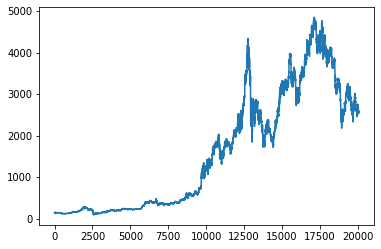

In [211]:
df.close.plot()

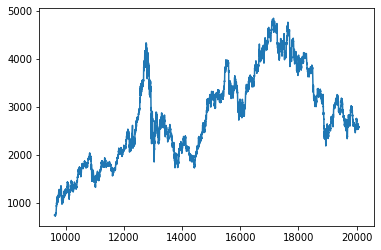

In [212]:
df.query('opentime >= 2021').close.plot()

In [213]:
df = df.query('opentime >= 2021').copy()
df.shape

(10465, 8)

### Decompose Time Series

Figure(432x288)
Figure(432x288)


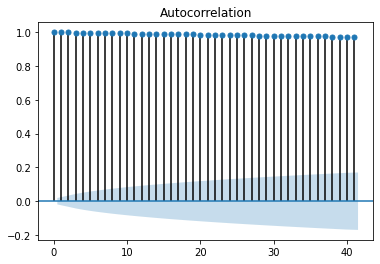

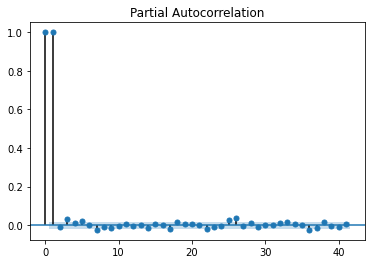

In [214]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.seasonal import MSTL
print(plot_acf(df.close))
print(plot_pacf(df.close))
# stl_kwargs = {"seasonal_deg": 0} 
# model = MSTL(df.close, periods=(24, 24 * 7), stl_kwargs=stl_kwargs)
# res = model.fit()
# res.plot()

### Create Lag/Diff Features

In [215]:
options_lags_feats = ['close','volume']
options_lags = [1,2,3,24,48]
for ff in options_lags_feats:
    for ll in options_lags:
        df[f'fx_{ff}_lag_{str(ll).zfill(3)}'] = df[ff].shift(ll)
        df[f'fx_{ff}_diff_{str(ll).zfill(3)}'] = df[ff].diff(ll)

In [216]:
df.columns[1::5]

Index(['closetime', 'volume', 'fx_close_diff_002', 'fx_close_lag_048',
       'fx_volume_diff_002', 'fx_volume_lag_048'],
      dtype='object')

In [217]:
df.shape

(10465, 28)

### Create Rolling Features

In [218]:
options_wndf_feats = ['close','volume']
options_wndf = [24,24*7]
for ff in options_wndf_feats:
    for ll in options_wndf:
        df[f'fx_{ff}_min_{str(ll).zfill(3)}'] = df[ff].rolling(ll).min()
        df[f'fx_{ff}_max_{str(ll).zfill(3)}'] = df[ff].rolling(ll).max()
        df[f'fx_{ff}_std_{str(ll).zfill(3)}'] = df[ff].rolling(ll).std()

In [219]:
df.columns[1::5]

Index(['closetime', 'volume', 'fx_close_diff_002', 'fx_close_lag_048',
       'fx_volume_diff_002', 'fx_volume_lag_048', 'fx_close_min_168',
       'fx_volume_std_024'],
      dtype='object')

In [220]:
df.shape

(10465, 40)

### Create TA Features

In [221]:
df = \
    df.assign(
        fx_sma_fast = lambda x : talib.SMA(x.close,8),
        fx_sma_slow = lambda x : x.close.rolling(24).mean(),
        fx_ema_fast = lambda x : talib.EMA(x.close,8),
        fx_ema_slow = lambda x : talib.EMA(x.close,24),
        fx_atr = lambda x : talib.ATR(x.high,x.low,x.close,12),
        fx_adx = lambda x : talib.ADX(x.high,x.low,x.close,20),
        fx_rsi = lambda x : talib.RSI(x.close,12),
        fx_bb_upper = lambda x : talib.BBANDS(x.close)[0],
        fx_bb_middle = lambda x : talib.BBANDS(x.close)[1],
        fx_bb_lower = lambda x : talib.BBANDS(x.close)[2],
    )

df.tail(2)

,opentime,closetime,open,high,low,close,volume,...,fx_ema_slow,fx_atr,fx_adx,fx_rsi,fx_bb_upper,fx_bb_middle,fx_bb_lower
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,...,2582.337709,19.186999,6.528699,42.159494,2595.340954,2580.537988,2565.735023
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,...,2581.029091,19.085580,6.748433,41.420362,2597.319099,2578.379980,2559.440862


In [222]:
df.columns[1::5]

Index(['closetime', 'volume', 'fx_close_diff_002', 'fx_close_lag_048',
       'fx_volume_diff_002', 'fx_volume_lag_048', 'fx_close_min_168',
       'fx_volume_std_024', 'fx_sma_slow', 'fx_rsi'],
      dtype='object')

In [223]:
df.shape

(10465, 50)

### Add all features at once

In [147]:
# qq = add_all_ta_features(
#     df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)
# qq.columns

### Enable Pattern Recognition Features

In [224]:
talib.get_function_groups().keys()

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])

In [225]:
# pattern_recognition_functions = [x for x in dir(talib) if x.startswith('CDL')]
pattern_recognition_functions = talib.get_function_groups().get('Pattern Recognition')
pattern_recognition_functions[1::10]

['CDL3BLACKCROWS',
 'CDLCLOSINGMARUBOZU',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'CDLMATHOLD',
 'CDLSPINNINGTOP']

In [226]:
# create pattern recognition features
pattern_features = {
    f'pt_{x.lower()}': getattr(talib,x)(df['open'],df['high'],df['low'],df['close'])
                    for x in pattern_recognition_functions
    }

In [227]:
df = df.assign(**pattern_features)
df.head(2)

,opentime,closetime,open,high,low,close,volume,...,pt_cdltakuri,pt_cdltasukigap,pt_cdlthrusting,pt_cdltristar,pt_cdlunique3river,pt_cdlupsidegap2crows,pt_cdlxsidegap3methods
9616,2021-01-01 00:00:00,2021-01-01 00:59:00,737.179993,740.000000,730.0,734.599976,98092.523438,...,0,0,0,0,0,0,0
9617,2021-01-01 01:00:00,2021-01-01 01:59:00,734.609985,750.400024,734.0,749.330017,164084.062500,...,0,0,0,0,0,0,0


In [228]:
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T['mean'].plot(kind='barh',figsize=(10,15))
df[[x for x in df.columns if x.startswith('pt_')]].describe().T

,count,mean,std,min,25%,50%,75%,max
pt_cdl2crows,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdl3blackcrows,10465.0,-0.009556,0.977531,-100.0,0.0,0.0,0.0,0.0
pt_cdl3inside,10465.0,0.086001,8.236764,-100.0,0.0,0.0,0.0,100.0
pt_cdl3linestrike,10465.0,0.038223,6.182624,-100.0,0.0,0.0,0.0,100.0
pt_cdl3outside,10465.0,0.028667,18.676567,-100.0,0.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...
pt_cdlthrusting,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdltristar,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdlunique3river,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pt_cdlupsidegap2crows,10465.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [229]:
df.columns[1::5]

Index(['closetime', 'volume', 'fx_close_diff_002', 'fx_close_lag_048',
       'fx_volume_diff_002', 'fx_volume_lag_048', 'fx_close_min_168',
       'fx_volume_std_024', 'fx_sma_slow', 'fx_rsi', 'pt_cdl3blackcrows',
       'pt_cdl3whitesoldiers', 'pt_cdlclosingmarubozu', 'pt_cdldojistar',
       'pt_cdlgapsidesidewhite', 'pt_cdlharamicross', 'pt_cdlidentical3crows',
       'pt_cdlladderbottom', 'pt_cdlmathold', 'pt_cdlrickshawman',
       'pt_cdlspinningtop', 'pt_cdlthrusting'],
      dtype='object')

In [230]:
df.shape

(10465, 111)

### Enable Pivot Levels

In [231]:
def PPS(high,low,close):
    if all([isinstance(item,(list,pd.core.series.Series,np.ndarray)) for item in (high,low,close)]):
        high = np.array(high,dtype='float32')
        low = np.array(low,dtype='float32')
        close = np.array(close,dtype='float32')
    else:
        raise Exception('Wrong type input data type')
    pp = (high + low + close)/3
    r1 = (2 * pp - low)
    s1 = (2 * pp - high)
    r2 = pp + high - low
    s2 = pp - high + low
    r3 = high + 2 * (pp - low)
    s3 = low - 2 * (high - pp)
    return {'pp':pp,'r1':r1,'s1':s1,'r2':r2,'s2':s2,'r3':r3,'s3':s3}

In [232]:
df = df.assign(**PPS(df.high,df.low,df.close))
df.tail(2)

,opentime,closetime,open,high,low,close,volume,...,pp,r1,s1,r2,s2,r3,s3
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,...,2572.613281,2585.226562,2555.026611,2602.813477,2542.413330,2615.426514,2524.826660
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,...,2565.189941,2574.569824,2556.599854,2583.159668,2547.219971,2592.539795,2538.629883


In [233]:
df.columns[1::5]

Index(['closetime', 'volume', 'fx_close_diff_002', 'fx_close_lag_048',
       'fx_volume_diff_002', 'fx_volume_lag_048', 'fx_close_min_168',
       'fx_volume_std_024', 'fx_sma_slow', 'fx_rsi', 'pt_cdl3blackcrows',
       'pt_cdl3whitesoldiers', 'pt_cdlclosingmarubozu', 'pt_cdldojistar',
       'pt_cdlgapsidesidewhite', 'pt_cdlharamicross', 'pt_cdlidentical3crows',
       'pt_cdlladderbottom', 'pt_cdlmathold', 'pt_cdlrickshawman',
       'pt_cdlspinningtop', 'pt_cdlthrusting', 'pp', 'r3'],
      dtype='object')

In [234]:
df.shape

(10465, 118)

### Examine Alternative Target Options

In [316]:
chkp = df.copy()
# df = chkp.copy()

In [317]:
df = \
    df.assign(
        #change_pct = lambda x : x.close.pct_change(),
        #change_chr = lambda x : x.close.pct_change().apply(np.sign),
    
        trg_close_04hrs_ahead = lambda x : x.close.shift(-4),
        trg_close_08hrs_ahead = lambda x : x.close.shift(-8),
        trg_close_12hrs_ahead = lambda x : x.close.shift(-12),
        trg_close_16hrs_ahead = lambda x : x.close.shift(-16),
        trg_close_20hrs_ahead = lambda x : x.close.shift(-20),
        trg_close_24hrs_ahead = lambda x : x.close.shift(-24),
        trg_close_48hrs_ahead = lambda x : x.close.shift(-48),
        trg_close_96hrs_ahead = lambda x : x.close.shift(-96),
    
        trg_delta_04hrs_ahead = lambda x : (x.close.shift(-4)/x.close)-1,
        trg_delta_08hrs_ahead = lambda x : (x.close.shift(-8)/x.close)-1,
        trg_delta_12hrs_ahead = lambda x : (x.close.shift(-12)/x.close)-1,
        trg_delta_16hrs_ahead = lambda x : (x.close.shift(-16)/x.close)-1,
        trg_delta_20hrs_ahead = lambda x : (x.close.shift(-20)/x.close)-1,
        trg_delta_24hrs_ahead = lambda x : (x.close.shift(-24)/x.close)-1,
        trg_delta_48hrs_ahead = lambda x : (x.close.shift(-48)/x.close)-1,
        trg_delta_96hrs_ahead = lambda x : (x.close.shift(-96)/x.close)-1,
    )
df.tail(100).head(2)

,opentime,closetime,open,high,low,close,volume,...,trg_delta_08hrs_ahead,trg_delta_12hrs_ahead,trg_delta_16hrs_ahead,trg_delta_20hrs_ahead,trg_delta_24hrs_ahead,trg_delta_48hrs_ahead,trg_delta_96hrs_ahead
19981,2022-03-08 21:00:00,2022-03-08 21:59:00,2552.040039,2562.750000,2546.719971,2557.320068,38991.250000,...,0.061373,0.076518,0.066312,0.072627,0.058409,0.017542,0.011078
19982,2022-03-08 22:00:00,2022-03-08 22:59:00,2557.320068,2574.030029,2554.780029,2567.229980,29236.652344,...,0.059367,0.073601,0.066223,0.055651,0.058055,0.017034,0.007245


In [318]:
# Review distributions of absolute returns for 4-8-16 etc. hours ahead
# 
for wnd in ['trg_delta_04hrs_ahead','trg_delta_08hrs_ahead',
            'trg_delta_12hrs_ahead','trg_delta_16hrs_ahead',
            'trg_delta_20hrs_ahead','trg_delta_24hrs_ahead',
            'trg_delta_48hrs_ahead','trg_delta_96hrs_ahead']:
    print(wnd)
    print(100*'=')
    print((pd.cut(
        x = df[wnd].abs(), 
        bins = [0, 0.025, 0.05, 0.1, 0.25, 0.5, 1.], 
        ).value_counts(normalize=True))*100)
    print(100*'-')
    print(df[wnd].apply(np.sign).value_counts(normalize=True)*100)
    print(100*'=')
    print()

trg_delta_04hrs_ahead
(0.0, 0.025]     80.351850
(0.025, 0.05]    15.364758
(0.05, 0.1]       3.986997
(0.1, 0.25]       0.296395
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_04hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.365931
-1.0    47.614951
 0.0     0.019119
Name: trg_delta_04hrs_ahead, dtype: float64

trg_delta_08hrs_ahead
(0.0, 0.025]     67.132198
(0.025, 0.05]    22.383777
(0.05, 0.1]       9.517888
(0.1, 0.25]       0.966137
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_08hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.778043
-1.0    47.193268
 0.0     0.028689
Name: trg_delta_08hrs_ahead, dtype: float64

trg_delta_12hrs_ahead
(0.0, 0.025]     57.481822
(0.025, 0.05]    26.846537
(0.05, 0.1]      13.624187
(0.1, 0.25]       2.028320
(0.25, 0.5]   

### Select Target

In [351]:
chkp2 = df.copy()
# df = chkp2.copy()

In [352]:
my_target = 'trg_delta_20hrs_ahead'
df['target_rgr'] = df[my_target]
df = df[[x for x in df.columns if not x.startswith('trg_')]]

In [355]:
my_bins = [0, 0.03, 0.05, 0.1, 0.25, 0.5, 1.]
my_labels = [f'delta_{x:.0%}_{y:.0%}' for x,y in zip(my_bins[:-1],my_bins[1:])]

In [356]:
(pd.cut(x = df.target_rgr.abs(), bins = my_bins, labels = my_labels).value_counts(normalize=True)*100)

delta_0%_3%       52.312111
delta_3%_5%       21.981809
delta_5%_10%      20.928674
delta_10%_25%      4.633796
delta_25%_50%      0.143609
delta_50%_100%     0.000000
Name: target_rgr, dtype: float64

In [357]:
df['target_clf'] = pd.cut(x = df.target_rgr.abs(), bins = my_bins, labels = my_labels)
df['target_sign'] = df.target_rgr.apply(np.sign)

### Profile Targets

In [358]:
df[[x for x in df.columns if x.startswith('target')]].describe(include='all')

,target_rgr,target_clf,target_sign
count,10445.000000,10445,10445.000000
unique,NaN,5,NaN
top,NaN,delta_0%_3%,NaN
freq,NaN,5464,NaN
mean,0.003644,NaN,0.074390
std,0.049734,NaN,0.997276
min,-0.318712,NaN,-1.000000
25%,-0.023765,NaN,-1.000000
50%,0.003882,NaN,1.000000
75%,0.032470,NaN,1.000000


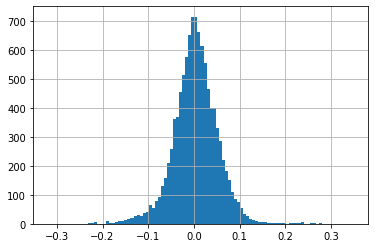

In [359]:
df.target_rgr.hist(bins=100)

delta_0%_3%       52.312111
delta_3%_5%       21.981809
delta_5%_10%      20.928674
delta_10%_25%      4.633796
delta_25%_50%      0.143609
delta_50%_100%     0.000000
Name: target_clf, dtype: float64


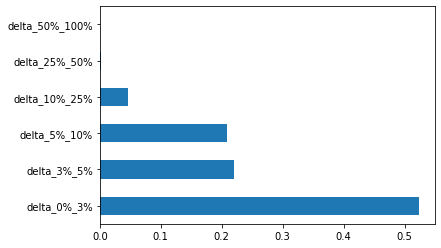

In [361]:
df.target_clf.value_counts(normalize=True).plot(kind='barh')
print(df.target_clf.value_counts(normalize=True)*100)

In [362]:
df.target_sign.value_counts(normalize=True)

 1.0    0.537195
-1.0    0.462805
Name: target_sign, dtype: float64

In [363]:
pd.crosstab(df.target_clf,df.target_sign,margins=True,normalize=True)

target_sign,-1.0,1.0,All
target_clf,,,
delta_0%_3%,0.253040,0.270081,0.523121
delta_3%_5%,0.101963,0.117855,0.219818
delta_5%_10%,0.082528,0.126759,0.209287
delta_10%_25%,0.025084,0.021254,0.046338
delta_25%_50%,0.000191,0.001245,0.001436
All,0.462805,0.537195,1.000000
